# Неделя 4. Сравнение алгоритмов классификации

Теперь мы наконец подойдем к обучению моделей классификации, сравним на кросс-валидации несколько алгоритмов, разберемся, какие параметры длины сессии (session_length и window_size) лучше использовать. Также для выбранного алгоритма построим кривые валидации (как качество классификации зависит от одного из гиперпараметров алгоритма) и кривые обучения (как качество классификации зависит от объема выборки).

**План 4 недели:**

* Часть 1. Сравнение нескольких алгоритмов на сессиях из 10 сайтов
* Часть 2. Выбор параметров – длины сессии и ширины окна
* Часть 3. Идентификация конкретного пользователя и кривые обучения

In [1]:
# pip install watermark
%load_ext watermark

In [2]:
%watermark -v -m -p numpy,scipy,pandas,matplotlib,statsmodels,sklearn -g

CPython 3.7.3
IPython 7.4.0

numpy 1.16.2
scipy 1.2.1
pandas 0.24.2
matplotlib 3.0.3
statsmodels 0.9.0
sklearn 0.20.3

compiler   : MSC v.1915 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 142 Stepping 10, GenuineIntel
CPU cores  : 8
interpreter: 64bit
Git hash   :


In [3]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from time import time
import itertools
import os
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
import pickle
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score

In [19]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = 'capstone_user_identification'

## Часть 1. Сравнение нескольких алгоритмов на сессиях из 10 сайтов

**Загрузим сериализованные ранее объекты X_sparse_10users и y_10users, соответствующие обучающей выборке для 10 пользователей.**

In [15]:
# в связи с тем, что не сделал четыре файла (в зависимости от пользователей) на первой неделе, прийдеться делать их сейчас. 
# Два сделаю на второй, так как там функция для создания разряженной матрицы, а здесь "y"

PATH_TO_DATA_2 = 'capstone_websites_data'

train_data_10users = pd.read_csv(os.path.join(PATH_TO_DATA_2, 'train_data_10users.csv'), 
                       index_col='session_id')

X_10users, y_10users = train_data_10users.iloc[:, :-1].values, \
                       train_data_10users.iloc[:, -1].values

with open(os.path.join(PATH_TO_DATA, 'y_10users.pkl'), 'wb') as y10_pkl:
    pickle.dump(y_10users, y10_pkl, protocol=2)
    

train_data_150users = pd.read_csv(os.path.join(PATH_TO_DATA_2, 'train_data_150users.csv'), 
                       index_col='session_id')

X_150users, y_150users = train_data_150users.iloc[:, :-1].values, \
                       train_data_150users.iloc[:, -1].values

with open(os.path.join(PATH_TO_DATA, 'y_150users.pkl'), 'wb') as y150_pkl:
    pickle.dump(y_150users, y150_pkl, protocol=2)

In [20]:
with open(os.path.join(PATH_TO_DATA, 'X_sparse_10users.pkl'), 'rb') as X_sparse_10users_pkl:
    X_sparse_10users = pickle.load(X_sparse_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 'y_10users.pkl'), 'rb') as y_10users_pkl:
    y_10users = pickle.load(y_10users_pkl)

In [21]:
X_sparse_10users.shape

(14061, 4913)

**Разобьем выборку на 2 части. На одной будем проводить кросс-валидацию, на второй – оценивать модель, обученную после кросс-валидации.**

In [22]:
X_train, X_valid, y_train, y_valid = train_test_split(X_sparse_10users, y_10users, 
                                                      test_size=0.3, 
                                                     random_state=17, stratify=y_10users)

**Зададим заранее тип кросс-валидации: 3-кратная, с перемешиванием, параметр random_state=17 – для воспроизводимости.**

In [8]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

**Вспомогательная функция для отрисовки кривых валидации после запуска GridSearchCV (или RandomizedCV).**

In [10]:
def plot_validation_curves(param_values, grid_cv_results_):
    train_mu, train_std = grid_cv_results_['mean_train_score'], grid_cv_results_['std_train_score']
    valid_mu, valid_std = grid_cv_results_['mean_test_score'], grid_cv_results_['std_test_score']
    train_line = plt.plot(param_values, train_mu, '-', label='train', color='green')
    valid_line = plt.plot(param_values, valid_mu, '-', label='test', color='red')
    plt.fill_between(param_values, train_mu - train_std, train_mu + train_std, edgecolor='none',
                     facecolor=train_line[0].get_color(), alpha=0.2)
    plt.fill_between(param_values, valid_mu - valid_std, valid_mu + valid_std, edgecolor='none',
                     facecolor=valid_line[0].get_color(), alpha=0.2)
    plt.legend()

**1. Обучите KNeighborsClassifier со 100 ближайшими соседями (остальные параметры оставьте по умолчанию, только n_jobs=-1 для распараллеливания) и посмотрите на долю правильных ответов на 3-кратной кросс-валидации (ради воспроизводимости используйте для этого объект StratifiedKFold skf) по выборке (X_train, y_train) и отдельно на выборке (X_valid, y_valid).**

In [11]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from time import time

In [12]:
knn = KNeighborsClassifier(n_neighbors=100, n_jobs=-1)

In [13]:
t_start = time()
scores = cross_val_score(knn, X_train, y_train, cv=skf)
print("CV scores:", scores)
print("mean:", np.mean(scores))
print("std:", np.std(scores))
print("Time elapsed: ", time()-t_start)

CV scores: [0.56925419 0.56968588 0.5552166 ]
mean: 0.5647188870063362
std: 0.006721445681604895
Time elapsed:  8.494625806808472


In [14]:
t_start = time()
scores = cross_val_score(knn, X_valid, y_valid, cv=skf)
print("CV scores:", scores)
print("mean:", np.mean(scores))
print("std:", np.std(scores))
print("Time elapsed: ", time()-t_start)

CV scores: [0.48688873 0.4975089  0.50819672]
mean: 0.49753144983493386
std: 0.008698965073972605
Time elapsed:  1.3075299263000488


In [15]:
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=100, p=2,
           weights='uniform')

In [16]:
t_start = time()
knn_pred = knn.predict(X_valid)
print(accuracy_score(y_valid, knn_pred))
print("Time elapsed: ", time()-t_start)

0.584024650391088
Time elapsed:  3.6717538833618164


**2. Обучите случайный лес (RandomForestClassifier) из 100 деревьев (для воспроизводимости random_state=17). Посмотрите на OOB-оценку (для этого надо сразу установить oob_score=True) и на долю правильных ответов на выборке (X_valid, y_valid). Для распараллеливания задайте n_jobs=-1.**

In [17]:
from sklearn.ensemble import RandomForestClassifier

In [18]:
clf = RandomForestClassifier(n_estimators=100, random_state=17, oob_score=True, n_jobs=-1)

In [19]:
t_start = time()
clf.fit(X_train, y_train)
print('Score: ', clf.score(X_train, y_train))
print("Time elapsed: ", time()-t_start)

Score:  0.9759195285511075
Time elapsed:  6.017571687698364


In [20]:
print(clf.oob_score_)

0.7172322698638488


In [21]:
t_start = time()
clf_pred = clf.predict(X_valid)
print(accuracy_score(y_valid, clf_pred))
print("Time elapsed: ", time()-t_start)

0.7312159279450107
Time elapsed:  0.10735368728637695


**3. Обучите логистическую регрессию (LogisticRegression) с параметром C по умолчанию и random_state=17 (для воспроизводимости). Посмотрите на долю правильных ответов на кросс-валидации (используйте объект skf, созданный ранее) и на выборке (X_valid, y_valid). Для распараллеливания задайте n_jobs=-1.**

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV

In [23]:
clf = LogisticRegression(random_state=17, n_jobs=-1)

In [24]:
t_start = time()
scores = cross_val_score(clf, X_train, y_train, cv=skf)
print("CV scores:", scores)
print("mean:", np.mean(scores))
print("std:", np.std(scores))
print("Time elapsed: ", time()-t_start)

CV scores: [0.75616438 0.76974687 0.75716901]
mean: 0.7610267543665875
std: 0.006179680775757465
Time elapsed:  2.1499271392822266


In [25]:
t_start = time()
scores = cross_val_score(knn, X_valid, y_valid, cv=skf)
print("CV scores:", scores)
print("mean:", np.mean(scores))
print("std:", np.std(scores))
print("Time elapsed: ", time()-t_start)

CV scores: [0.48688873 0.4975089  0.50819672]
mean: 0.49753144983493386
std: 0.008698965073972605
Time elapsed:  1.2372586727142334


In [26]:
clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=-1,
          penalty='l2', random_state=17, solver='warn', tol=0.0001,
          verbose=0, warm_start=False)

In [27]:
t_start = time()
clf_pred = clf.predict(X_valid)
print(accuracy_score(y_valid, clf_pred))
print("Time elapsed: ", time()-t_start)

0.7817018250770325
Time elapsed:  0.004979133605957031


Почитайте документацию к LogisticRegressionCV. Логистическая регрессия хорошо изучена, и для нее существуют алгоритмы быстрого подбора параметра регуляризации C (быстрее, чем с GridSearchCV).

С помощью LogisticRegressionCV подберите параметр C для LogisticRegression сначала в широком диапазоне: 10 значений от 1e-4 до 1e2, используйте logspace из NumPy. Укажите у LogisticRegressionCV параметры multi_class='multinomial' и random_state=17. Для кросс-валидации используйте объект skf, созданный ранее. Для распараллеливания задайте n_jobs=-1.

Нарисуйте кривые валидации по параметру C.

In [28]:
t_start = time()
logit_c_values1 = np.logspace(-4,2,10)
logit_grid_searcher1 = LogisticRegressionCV(logit_c_values1, cv=skf, multi_class='multinomial', random_state=17, n_jobs=-1)
logit_grid_searcher1.fit(X_train, y_train)
print("Time elapsed: ", time()-t_start)

Time elapsed:  14.351906061172485


Средние значения доли правильных ответов на кросс-валидации по каждому из 10 параметров C.

In [29]:
logit_mean_cv_scores1 = np.mean(logit_grid_searcher1.scores_[1], axis=0)

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение C.

In [30]:
print(logit_mean_cv_scores1.max(), " - ", logit_c_values1[np.argmax(logit_mean_cv_scores1)])

0.7590972822063531  -  1.0


Нарисуйте график зависимости доли правильных ответов на кросс-валидации от C.

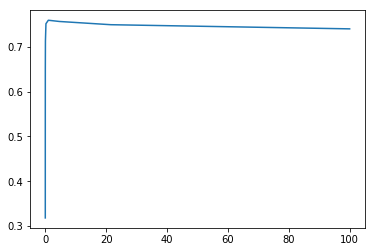

In [31]:
plt.plot(logit_c_values1, logit_mean_cv_scores1);

**Теперь то же самое, только значения параметра C перебирайте в диапазоне np.linspace(0.1, 7, 20). Опять нарисуйте кривые валидации, определите максимальное значение доли правильных ответов на кросс-валидации.**

In [74]:
t_start = time()
logit_c_values2 = np.linspace(0.1, 7, 20)
logit_grid_searcher2 = LogisticRegressionCV(Cs=logit_c_values2, cv=skf, multi_class='multinomial', random_state=17, n_jobs=-1)
logit_grid_searcher2.fit(X_train, y_train)
print("Time elapsed: ", time()-t_start)

Time elapsed:  24.426214456558228


Средние значения доли правильных ответов на кросс-валидации по каждому из 10 параметров C.

In [76]:
logit_mean_cv_scores2 = np.mean(logit_grid_searcher2.scores_[1], axis=0)

In [34]:
logit_mean_cv_scores2

array([0.7354267 , 0.75879138, 0.75838615, 0.75767442, 0.75808192,
       0.75777741, 0.75808257, 0.75757484, 0.75716896, 0.75676347,
       0.75727132, 0.7565601 , 0.75605243, 0.7555448 , 0.75524069,
       0.75473315, 0.75432726, 0.75473383, 0.75432754, 0.75381935])

In [35]:
logit_c_values2

array([0.1       , 0.46315789, 0.82631579, 1.18947368, 1.55263158,
       1.91578947, 2.27894737, 2.64210526, 3.00526316, 3.36842105,
       3.73157895, 4.09473684, 4.45789474, 4.82105263, 5.18421053,
       5.54736842, 5.91052632, 6.27368421, 6.63684211, 7.        ])

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение C.

In [36]:
print(logit_mean_cv_scores2.max(), " - ", logit_c_values2[np.argmax(logit_mean_cv_scores2)])

0.7587913824075879  -  0.4631578947368421


Нарисуйте график зависимости доли правильных ответов на кросс-валидации от C.

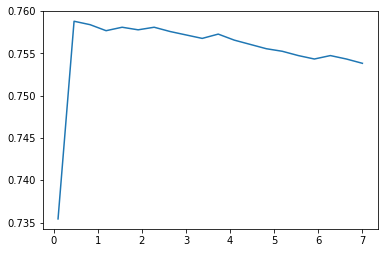

In [37]:
plt.plot(logit_c_values2, logit_mean_cv_scores2);

Выведите долю правильных ответов на выборке (X_valid, y_valid) для логистической регрессии с лучшим найденным значением C.

In [38]:
t_start = time()
logit2_pred = logit_grid_searcher2.predict(X_valid)
print(accuracy_score(y_valid, logit2_pred))
print("Time elapsed: ", time()-t_start)

0.7748281583313581
Time elapsed:  0.002197265625


**4. Обучите линейный SVM (LinearSVC) с параметром C=1 и random_state=17 (для воспроизводимости). Посмотрите на долю правильных ответов на кросс-валидации (используйте объект skf, созданный ранее) и на выборке (X_valid, y_valid).**

In [39]:
from sklearn.svm import LinearSVC

In [40]:
t_start = time()
svm = LinearSVC(C=1, random_state=17)
scores_svm = cross_val_score(svm, X_train, y_train, cv=skf, n_jobs=-1)
print("CV scores:", scores_svm)
print("mean:", np.mean(scores_svm))
print("std:", np.std(scores_svm))
print("Time elapsed: ", time()-t_start)

CV scores: [0.74672755 0.76059774 0.75106772]
mean: 0.7527976723012523
std: 0.005793105610011066
Time elapsed:  3.1112382411956787


In [41]:
t_start = time()
svm.fit(X_train, y_train)
svm_pred = svm.predict(X_valid)
print(accuracy_score(y_valid, svm_pred))
print("Time elapsed: ", time()-t_start)

0.7769613652524295
Time elapsed:  4.54899525642395


С помощью GridSearchCV подберите параметр C для SVM сначала в широком диапазоне: 10 значений от 1e-4 до 1e4, используйте linspace из NumPy. Нарисуйте кривые валидации.

In [42]:
t_start = time()

svm_params1 = {'C': np.linspace(1e-4, 1e4, 10)}

svm_grid_searcher1 = GridSearchCV(svm, param_grid=svm_params1, cv=skf, n_jobs=-1)
svm_grid_searcher1.fit(X_train, y_train)

print("Time elapsed: ", time()-t_start)

Time elapsed:  30.767382621765137


Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение C.

In [43]:
svm_grid_searcher1.best_params_

{'C': 3333.3334000000004}

In [44]:
svm_grid_searcher1.best_score_

0.6845153424100793

Нарисуйте график зависимости доли правильных ответов на кросс-валидации от C

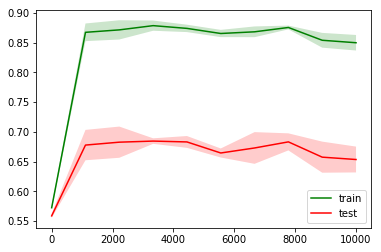

In [45]:
plot_validation_curves(svm_params1['C'], svm_grid_searcher1.cv_results_)

**Но мы помним, что с параметром регуляризации по умолчанию (С=1) на кросс-валидации доля правильных ответов выше. Это тот случай (не редкий), когда можно ошибиться и перебирать параметры не в том диапазоне (причина в том, что мы взяли равномерную сетку на большом интервале и упустили действительно хороший интервал значений C). Здесь намного осмысленней подбирать C в районе 1, к тому же, так модель быстрее обучается, чем при больших C.**

**С помощью GridSearchCV подберите параметр C для SVM в диапазоне (1e-3, 1), 30 значений, используйте linspace из NumPy. Нарисуйте кривые валидации.**

In [7]:
t_start = time()

svm_params2 = {'C': np.linspace(1e-3, 1, 30)}

svm_grid_searcher2 = GridSearchCV(svm, param_grid=svm_params2, cv=skf, n_jobs=-1)
svm_grid_searcher2.fit(X_train, y_train)

print("Time elapsed: ", time()-t_start)

NameError: name 'svm' is not defined

In [47]:
svm_grid_searcher2.best_params_

{'C': 0.10434482758620689}

In [48]:
svm_grid_searcher2.best_score_

0.764681975208291

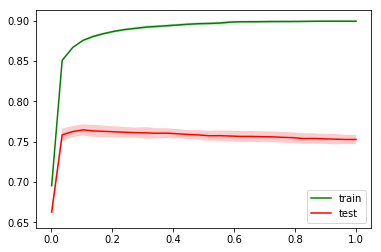

In [49]:
plot_validation_curves(svm_params2['C'], svm_grid_searcher2.cv_results_)

In [50]:
t_start = time()

svm2_pred = svm_grid_searcher2.predict(X_valid)
print(accuracy_score(y_valid, svm2_pred))

print("Time elapsed: ", time()-t_start)

0.7807537331121118
Time elapsed:  0.0029938220977783203


In [51]:
#перетаскиваем нашу функцию
def prepare_sparse_train_set_window(path_to_csv_files, path_to_pkl_files, session_length=10, window_size=10):
    
    stock_files = sorted(glob(path_to_csv_files))
    
    #create dataframe from file
    df = pd.concat((pd.read_csv(file) for file in stock_files), ignore_index=True)
    
    #sorted site
    df_site_dict = path_to_pkl_files
    
    #create number list site
    list_all_site = []
    user_list = []
    user = 1
    for filename in stock_files:
        tmp_df = pd.read_csv(filename)
        list_site = []
        for site in tmp_df.site:
            list_site.append(df_site_dict.get(site))
        count = 0
        for start in range(0, (len(list_site) + window_size), window_size):
            ind_1 = start
            ind_2 = start + session_length
            #print(start)
            if ind_2 <= (len(list_site)-1):
                sess = list_site[ind_1 : ind_2]
                list_all_site.append(sess)
                user_list.append(user)
            else:
                if(len(list_site[ind_1:])==0):
                    break
                sess = list_site[ind_1:] + [0 for _ in range(session_length - len(list_site[ind_1:]))]
                list_all_site.append(sess)
                user_list.append(user)
        user = user + 1
        
    tmp_arr = np.array(list_all_site)
    row = 0
    width = 0
    rows = []
    cols = []
    data = []

    for arr in tmp_arr:
        unique, counts = np.unique(arr, return_counts=True)
        for key, value in dict(zip(unique, counts)).items():
            width = width + 1
            if key != 0:
                rows.append(row)
                cols.append(key-1)
                data.append(value)
        row = row + 1
        
    B = sps.coo_matrix((data, (rows, cols))).tocsr()
    return(B, user_list)

In [52]:
path_3 = os.path.join(PATH_TO_DATA, '3users/*.csv')
path_10 = os.path.join(PATH_TO_DATA, '10users/*.csv')
path_150 = os.path.join(PATH_TO_DATA, '150users/*.csv')

# change data path

path_pkl = os.path.join(PATH_TO_DATA, 'site_freq_3users.pkl')
unpickled_df_3 = pd.read_pickle(path_pkl)
#print(unpickled_df_3)
path_pkl_10 = os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl')
unpickled_df_10 = pd.read_pickle(path_pkl_10)
#print(unpickled_df_10)
path_pkl_150 = os.path.join(PATH_TO_DATA, 'site_freq_150users.pkl')
unpickled_df_150 = pd.read_pickle(path_pkl_150)
#print(unpickled_df_150)

In [53]:
from glob import glob
import scipy.sparse as sps

In [155]:
X_sparse_10users_15_5, y_sparse_10users_15_5 = prepare_sparse_train_set_window(path_10, unpickled_df_10, 15, 5)

## Часть 2. Выбор параметров – длины сессии и ширины окна

**Возьмем LinearSVC, показавший лучшее качество на кросс-валидации в 1 части, и проверим его работу еще на 8 выборках для 10 пользователей (с разными сочетаниями параметров session_length и window_size). Поскольку тут уже вычислений побольше, мы не будем каждый раз заново подбирать параметр регуляризации C.**

**Определите функцию model_assessment, ее документация описана ниже. Обратите внимание на все детали. Например, на то, что разбиение выборки с train_test_split должно быть стратифицированным. Не теряйте нигде random_state.**

In [4]:
def model_assessment(estimator, path_to_X_pickle, path_to_y_pickle, cv, random_state=17, test_size=0.3):
    '''
    Estimates CV-accuracy for (1 - test_size) share of (X_sparse, y) 
    loaded from path_to_X_pickle and path_to_y_pickle and holdout accuracy for (test_size) share of (X_sparse, y).
    The split is made with stratified train_test_split with params random_state and test_size.
    
    :param estimator – Scikit-learn estimator (classifier or regressor)
    :param path_to_X_pickle – path to pickled sparse X (instances and their features)
    :param path_to_y_pickle – path to pickled y (responses)
    :param cv – cross-validation as in cross_val_score (use StratifiedKFold here)
    :param random_state –  for train_test_split
    :param test_size –  for train_test_split
    
    :returns mean CV-accuracy for (X_train, y_train) and accuracy for (X_valid, y_valid) where (X_train, y_train)
    and (X_valid, y_valid) are (1 - test_size) and (testsize) shares of (X_sparse, y).
    '''
    
    ''' ВАШ КОД ЗДЕСЬ '''
    
    with open(path_to_X_pickle, 'rb') as X_sparse_10users_pkl:
        X_sparse_10users = pickle.load(X_sparse_10users_pkl)
    with open(path_to_y_pickle, 'rb') as y_10users_pkl:
        y_10users = pickle.load(y_10users_pkl)
        
    X_train, X_valid, y_train, y_valid = train_test_split(X_sparse_10users, y_10users, 
                                                      test_size=0.3, 
                                                     random_state=17, stratify=y_10users)
    
    t_start = time()
    scores_svm = cross_val_score(estimator, X_train, y_train, cv=skf, n_jobs=-1)
    #print("CV scores:", scores_svm)
    #print("mean:", np.mean(scores_svm))
    #print("std:", np.std(scores_svm))
    #print("Time elapsed: ", time()-t_start)
    
    t_start = time()
    estimator.fit(X_train, y_train)
    svm_pred = estimator.predict(X_valid)
    #print(accuracy_score(y_valid, svm_pred))
    #print("Time elapsed: ", time()-t_start)
    
    return(np.mean(scores_svm), accuracy_score(y_valid, svm_pred), " Time elapsed: ", time()-t_start)

In [5]:
PATH_TO_DATA = 'capstone_user_identification'

In [6]:
model_assessment(svm_grid_searcher2.best_estimator_, 
                 os.path.join(PATH_TO_DATA, 'X_sparse_10users.pkl'),
        os.path.join(PATH_TO_DATA, 'y_10users.pkl'), skf, random_state=17, test_size=0.3)

NameError: name 'svm_grid_searcher2' is not defined

**Примените функцию model_assessment для лучшего алгоритма из предыдущей части (а именно, svm_grid_searcher2.best_estimator_) и 9 выборок вида с разными сочетаниями параметров session_length и window_size для 10 пользователей. Выведите в цикле параметры session_length и window_size, а также результат вывода функции model_assessment. Удобно сделать так, чтоб model_assessment возвращала 3-им элементом время, за которое она выполнилась. На моем ноуте этот участок кода выполнился за 20 секунд. Но со 150 пользователями каждая итерация занимает уже несколько минут.**

Здесь для удобства стоит создать копии ранее созданных pickle-файлов X_sparse_10users.pkl, X_sparse_150users.pkl, y_10users.pkl и y_150users.pkl, добавив к их названиям s10_w10, что означает длину сессии 10 и ширину окна 10.

In [73]:
#для 10 пользователей
estimator = svm_grid_searcher2.best_estimator_

for window_size, session_length in itertools.product([10, 7, 5], [15, 10, 7, 5]):
    if window_size <= session_length and (window_size, session_length):
        path_to_X_pkl = 'capstone_websites_data_1/X_sparse_10users_s' + \
                        str(session_length) + '_w' + str(window_size) + '.pkl'
        path_to_y_pkl = 'capstone_websites_data_1/y_10users_s' + \
                        str(session_length) + '_w' + str(window_size) + '.pkl'
        print("Session length: {}, Window size: {}".format(session_length, window_size))
        print(model_assessment(estimator, path_to_X_pkl, path_to_y_pkl, skf, random_state=17, test_size=0.3))

Session length: 15, Window size: 10
(0.8238214955278105, 0.8404835269021095, ' Time elapsed: ', 2.4413769245147705)
Session length: 10, Window size: 10
(0.7646853244550981, 0.7807537331121118, ' Time elapsed: ', 1.3739533424377441)
Session length: 15, Window size: 7
(0.8479403769844098, 0.8543222166915547, ' Time elapsed: ', 3.2437942028045654)
Session length: 10, Window size: 7
(0.7970161463734652, 0.8073668491786958, ' Time elapsed: ', 1.7622921466827393)
Session length: 7, Window size: 7
(0.7529891114830342, 0.7617388418782147, ' Time elapsed: ', 1.1328918933868408)
Session length: 15, Window size: 5
(0.868001372554347, 0.8752963489805595, ' Time elapsed: ', 4.2376203536987305)
Session length: 10, Window size: 5
(0.8159247205318039, 0.8245614035087719, ' Time elapsed: ', 2.568331003189087)
Session length: 7, Window size: 5
(0.774058674563226, 0.7853247984826932, ' Time elapsed: ', 1.5714776515960693)
Session length: 5, Window size: 5
(0.7252830650398828, 0.7362494073020389, ' Time e

In [74]:
#для 150 пользователей
estimator = svm_grid_searcher2.best_estimator_

for window_size, session_length in itertools.product([10, 7, 5], [15, 10, 7, 5]):
    if window_size <= session_length and (window_size, session_length):
        path_to_X_pkl = 'capstone_websites_data_1/X_sparse_150users_s' + \
                        str(session_length) + '_w' + str(window_size) + '.pkl'
        path_to_y_pkl = 'capstone_websites_data_1/y_150users_s' + \
                        str(session_length) + '_w' + str(window_size) + '.pkl'
        print("Session length: {}, Window size: {}".format(session_length, window_size))
        print(model_assessment(estimator, path_to_X_pkl, path_to_y_pkl, skf, random_state=17, test_size=0.3))

Session length: 15, Window size: 10
(0.5491186386819248, 0.5751471804602735, ' Time elapsed: ', 124.27188539505005)
Session length: 10, Window size: 10
(0.4612588999427913, 0.4836276942538802, ' Time elapsed: ', 87.6054573059082)
Session length: 15, Window size: 7
(0.5840534183025796, 0.6086282658309773, ' Time elapsed: ', 218.67858839035034)
Session length: 10, Window size: 7
(0.502227519482276, 0.5239295568348264, ' Time elapsed: ', 160.65876722335815)
Session length: 7, Window size: 7
(0.43638649409423974, 0.45295840855673264, ' Time elapsed: ', 117.05255031585693)
Session length: 15, Window size: 5
(0.6137972358901919, 0.635980921789069, ' Time elapsed: ', 390.999564409256)
Session length: 10, Window size: 5
(0.5249611576924046, 0.5459069450528058, ' Time elapsed: ', 245.98754835128784)
Session length: 7, Window size: 5
(0.46492516791374255, 0.48184649827225384, ' Time elapsed: ', 173.62700843811035)
Session length: 5, Window size: 5
(0.40858659509908596, 0.42171606560568453, ' Tim

## Часть 3. Идентификация конкретного пользователя и кривые обучения¶

**Поскольку может разочаровать, что многоклассовая доля правильных ответов на выборке из 150 пользовалей невелика, порадуемся тому, что конкретного пользователя можно идентифицировать достаточно хорошо.**

**Загрузим сериализованные ранее объекты X_sparse_150users и y_150users, соответствующие обучающей выборке для 150 пользователей с параметрами (session_length, window_size) = (10,10). Так же точно разобьем их на 70% и 30%.**

In [9]:
PATH_TO_DATA = 'capstone_websites_data_1'

with open(os.path.join(PATH_TO_DATA, 'X_sparse_150users_s10_w10.pkl'), 'rb') as X_sparse_150users_pkl:
     X_sparse_150users = pickle.load(X_sparse_150users_pkl)
with open(os.path.join(PATH_TO_DATA, 'y_150users_s10_w10.pkl'), 'rb') as y_150users_pkl:
    y_150users = pickle.load(y_150users_pkl)

In [10]:
X_train_150, X_valid_150, y_train_150, y_valid_150 = train_test_split(X_sparse_150users, 
                                                                      y_150users, test_size=0.3, 
                                                     random_state=17, stratify=y_150users)

**Обучите LogisticRegressionCV для одного значения параметра C (лучшего на кросс-валидации в 1 части, используйте точное значение, не на глаз). Теперь будем решать 150 задач "Один-против-Всех", поэтому укажите аргумент multi_class='ovr'. Как всегда, где возможно, указывайте n_jobs=-1 и random_state=17.**

In [77]:
t_start = time()
logit_cv_150users = LogisticRegressionCV(Cs = [logit_grid_searcher2.Cs_[logit_mean_cv_scores2.argmax()]], cv=skf, multi_class='ovr', random_state=17, n_jobs=-1)
logit_cv_150users.fit(X_train_150, y_train_150)
print("Time elapsed ", time()-t_start)

Time elapsed  298.90029883384705


In [95]:
t_start = time()
logit_cv_150users = LogisticRegressionCV(Cs = [logit_grid_searcher2.Cs_[2]], cv=skf, multi_class='ovr', random_state=17, n_jobs=-1)
logit_cv_150users.fit(X_train_150, y_train_150)
print("Time elapsed ", time()-t_start)

Time elapsed  380.39993691444397


In [101]:
t_start = time()
logit_cv_150users = LogisticRegressionCV(Cs = [logit_grid_searcher2.Cs_[3]], cv=skf, multi_class='ovr', random_state=17, n_jobs=-1)
logit_cv_150users.fit(X_train_150, y_train_150)
print("Time elapsed ", time()-t_start)

Time elapsed  434.44434881210327


In [24]:
t_start = time()
logit_cv_150users = LogisticRegressionCV(Cs = [logit_grid_searcher2.Cs_[4]], cv=skf, multi_class='ovr', random_state=17, n_jobs=-1)
logit_cv_150users.fit(X_train_150, y_train_150)
print("Time elapsed ", time()-t_start)

Time elapsed  331.97297859191895


In [30]:
t_start = time()
logit_cv_150users = LogisticRegressionCV(Cs = [logit_grid_searcher2.Cs_[5]], cv=skf, multi_class='ovr', random_state=17, n_jobs=-1)
logit_cv_150users.fit(X_train_150, y_train_150)
print("Time elapsed ", time()-t_start)

Time elapsed  407.19827604293823


In [37]:
t_start = time()
logit_cv_150users = LogisticRegressionCV(Cs = [logit_grid_searcher2.Cs_[6]], cv=skf, multi_class='ovr', random_state=17, n_jobs=-1)
logit_cv_150users.fit(X_train_150, y_train_150)
print("Time elapsed ", time()-t_start)

Time elapsed  395.187148809433


In [44]:
t_start = time()
logit_cv_150users = LogisticRegressionCV(Cs = [logit_grid_searcher2.Cs_[7]], cv=skf, multi_class='ovr', random_state=17, n_jobs=-1)
logit_cv_150users.fit(X_train_150, y_train_150)
print("Time elapsed ", time()-t_start)

Time elapsed  392.49987268447876


In [52]:
t_start = time()
logit_cv_150users = LogisticRegressionCV(Cs = [logit_grid_searcher2.Cs_[8]], cv=skf, multi_class='ovr', random_state=17, n_jobs=-1)
logit_cv_150users.fit(X_train_150, y_train_150)
print("Time elapsed ", time()-t_start)

Time elapsed  398.14973974227905


In [59]:
t_start = time()
logit_cv_150users = LogisticRegressionCV(Cs = [logit_grid_searcher2.Cs_[9]], cv=skf, multi_class='ovr', random_state=17, n_jobs=-1)
logit_cv_150users.fit(X_train_150, y_train_150)
print("Time elapsed ", time()-t_start)

Time elapsed  408.53145813941956


In [66]:
t_start = time()
logit_cv_150users = LogisticRegressionCV(Cs = [logit_grid_searcher2.Cs_[10]], cv=skf, multi_class='ovr', random_state=17, n_jobs=-1)
logit_cv_150users.fit(X_train_150, y_train_150)
print("Time elapsed ", time()-t_start)

Time elapsed  360.2887694835663


In [78]:
Cs = logit_grid_searcher2.Cs_[1]
Cs

0.4631578947368421

**Посмотрите на средние доли правильных ответов на кросс-валидации в задаче идентификации каждого пользователя по отдельности.**

In [79]:
cv_scores_by_user = {}
for user_id in logit_cv_150users.scores_:
    print('User {}, CV score: {}'.format(user_id, (np.mean(logit_cv_150users.scores_[user_id], axis=0))))

User 1, CV score: [0.99583965]
User 2, CV score: [0.99623616]
User 3, CV score: [0.99514142]
User 4, CV score: [0.99176296]
User 5, CV score: [0.99003265]
User 6, CV score: [0.99459929]
User 7, CV score: [0.99362959]
User 8, CV score: [0.98574744]
User 9, CV score: [0.99797737]
User 10, CV score: [0.99493288]
User 11, CV score: [0.99448474]
User 12, CV score: [0.99360872]
User 13, CV score: [0.99699733]
User 14, CV score: [0.99496407]
User 15, CV score: [0.99636126]
User 16, CV score: [0.9963197]
User 17, CV score: [0.99051226]
User 18, CV score: [0.99435963]
User 19, CV score: [0.99471389]
User 20, CV score: [0.99119015]
User 21, CV score: [0.97982591]
User 22, CV score: [0.99682011]
User 23, CV score: [0.99450519]
User 24, CV score: [0.99065811]
User 25, CV score: [0.99660116]
User 26, CV score: [0.99420289]
User 27, CV score: [0.99499537]
User 28, CV score: [0.99107504]
User 29, CV score: [0.98456961]
User 30, CV score: [0.99719534]
User 31, CV score: [0.99704948]
User 32, CV score:

**Результаты кажутся впечатляющими, но возможно, мы забываем про дисбаланс классов, и высокую долю правильных ответов можно получить константным прогнозом. Посчитайте для каждого пользователя разницу между долей правильных ответов на кросс-валидации (только что посчитанную с помощью LogisticRegressionCV) и долей меток в y_train_150, отличных от ID этого пользователя (именно такую долю правильных ответов можно получить, если классификатор всегда "говорит", что это не пользователь с номером i в задаче классификации i-vs-All).**

In [80]:
y_train_150 = np.array(y_train_150, dtype=np.int)

In [81]:
class_distr = np.bincount(y_train_150.astype('int'))
acc_diff_vs_constant=[]
for user_id in np.unique(y_train_150):
    acc_diff_vs_constant.append(np.mean(logit_cv_150users.scores_[user_id], axis=0)-((class_distr.sum() - \
                                                                                      class_distr[user_id])/class_distr.sum()))
    #print(user_id)

In [82]:
num_better_than_default = (np.array(acc_diff_vs_constant) > 0).sum()

In [83]:
num_better_than_default/150

0.9133333333333333

In [51]:
cla.predict

NameError: name 'cla' is not defined